# The Very Basics of Musical Instruments Classification using Machine Learning
## MFCC, SVM 


## Imports

In [1]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
# from sklearn.externals 
import joblib

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Configurations
path='./audio/london_phill_dataset_multi/'

# Sampling rate
fs = 44100

## Get filenames

In [2]:
# Get files in data path
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 9111 audio files in ./audio/london_phill_dataset_multi/


## Prepare labels from filenames

In [3]:
# Get Labels
labels =[]
classes=['flute', 'sax', 'oboe', 'cello', 'trumpet', 'viola', 'violin', 'percussion']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', \
            'viola':'yellow', 'violin':'purple', 'percussion':'pink'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [4]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

7 classes: cello, flute, oboe, sax, trumpet, viola, violin


## Load audio files

In [5]:
# Load audio files, calculate features and create feature vectors
data = []
for i,f in enumerate(files):
    if np.mod(i, 500) == 499:
        print ("get %d of %d"%(i+1, len(files)))
    y, sr = librosa.load(f, sr=fs)
    y /= y.max() #Normalize
    if len(y) < 2:
        error("Error loading %s" % f)
        continue
    data.append((y, sr))
print ("Loaded %d audio files"%len(files))

get 500 of 9111
get 1000 of 9111
get 1500 of 9111
get 2000 of 9111
get 2500 of 9111
get 3000 of 9111
get 3500 of 9111
get 4000 of 9111
get 4500 of 9111
get 5000 of 9111
get 5500 of 9111
get 6000 of 9111
get 6500 of 9111
get 7000 of 9111
get 7500 of 9111
get 8000 of 9111
get 8500 of 9111
get 9000 of 9111
Loaded 9111 audio files


## Function to Calculate Audio Features: MFCC

In [6]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    return feature_vector

## Parameters for MFCC

In [7]:
# Signal Processing Parameters
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 256       # Number of Mel bands
n_mfcc = 43        # Number of MFCCs

## Calculate Feature Vectors

In [8]:
feature_vectors = []
# sound_paths = []
for i in range(len(data)):
    y = data[i][0]
    feat = get_features(y, sr)
    feature_vectors.append(feat)
    if np.mod(i, 500) == 499:
        print("Calculated %d feature vectors"%(i+1))
    # sound_paths.append(f)
print("Done. Calculated %d feature vectors"%len(feature_vectors))

Calculated 500 feature vectors
Calculated 1000 feature vectors
Calculated 1500 feature vectors
Calculated 2000 feature vectors
Calculated 2500 feature vectors
Calculated 3000 feature vectors
Calculated 3500 feature vectors
Calculated 4000 feature vectors
Calculated 4500 feature vectors
Calculated 5000 feature vectors
Calculated 5500 feature vectors
Calculated 6000 feature vectors
Calculated 6500 feature vectors
Calculated 7000 feature vectors
Calculated 7500 feature vectors
Calculated 8000 feature vectors
Calculated 8500 feature vectors
Calculated 9000 feature vectors
Done. Calculated 9111 feature vectors


## Standardization: Zero-Mean and Unit-Variance

In [9]:
# Scale features using Standard Scaler
scaled_feature_vectors = (feature_vectors-np.mean(feature_vectors))/np.std(feature_vectors)
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (9111, 43)


## Save / Load Feature Vector

In [10]:
filename="mfcc_feature_vectors_256_43.pl"
filename2="mfcc_raw_feature_vectors_256_43.pl"

# Load mfcc features from saved file
# with open(filename, "rb") as f:
#    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )
# with open(filename2, "rb") as f:
#    feature_vectors = pickle.load( open( filename2, "rb" ) )

# Save feature_vectors for future use
with open(filename, "wb") as f:
    pickle.dump( scaled_feature_vectors, f )
with open(filename2, "wb") as f:
    pickle.dump( feature_vectors, f )

## Machine Learning Parameters

In [11]:
# Machine Learning Parameters
testset_size = 0.25 # Percentage of data for Testing
n_neighbors = 1     # Number of neighbors for kNN Classifier

## Train and Test Sets

In [12]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [13]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)
print("test_classes:",test_classes)

train_set shape: (6833, 43)
test_set shape: (2278, 43)
train_classes shape: (6833,)
test_classes shape: (2278,)
test_classes: [0 0 6 ... 3 6 6]


## SVM Classification

In [14]:
# SVM
svclassifier = SVC(kernel='rbf', C=10.0, gamma=0.07) 
svclassifier1 = SVC(kernel='rbf', C=10.0, gamma=0.07) 

In [15]:
# SVM
svclassifier.fit(train_set, train_classes);
svclassifier1.fit(scaled_feature_vectors, classes_num);

## Evaluation

In [16]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = svclassifier.predict(test_set)
print("Predicted Label: ", predicted_labels)

Predicted Label:  [0 0 6 ... 3 6 6]


In [17]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.4f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.98618785 0.99492386 1.         0.99386503 0.97979798 1.
 0.99725275]
Precision:  [1.         1.         1.         0.98780488 0.98979592 0.98275862
 0.9877551 ]
F1-Score:  [0.9930459  0.99745547 1.         0.99082569 0.98477157 0.99130435
 0.9924812 ]
Accuracy: 0.9930  , 2262
Number of samples: 2278


In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [19]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

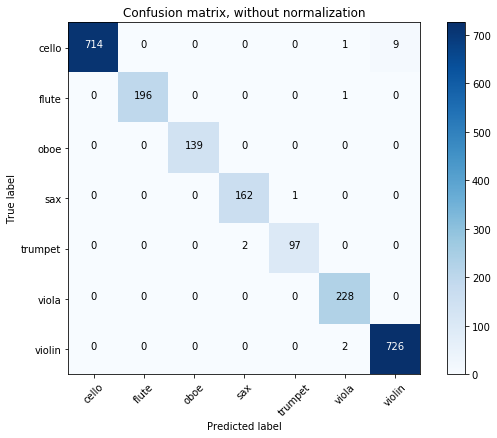

In [20]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [21]:
# Find wrong predicted samples indexes
# wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
# wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [22]:
# Find wrong predicted audio files
# print(np.array(labels)[test_index[wrong_predictions]])
# print(predicted_labels[wrong_predictions].T)
# print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
# print(np.array(files)[test_index[wrong_predictions]])

## Evaluate the performance for real-world music pieces

In [23]:
# Plot histogram of predicted labels:

def plot_hist(label, answer, title):
    # calculate percentage
    num_flute = 100*np.count_nonzero(labelencoder.inverse_transform(label) == 'flute')/len(label)
    num_sax = 100*np.count_nonzero(labelencoder.inverse_transform(label) == 'sax')/len(label)
    num_oboe = 100*np.count_nonzero(labelencoder.inverse_transform(label) == 'oboe')/len(label)
    num_cello = 100*np.count_nonzero(labelencoder.inverse_transform(label) == 'cello')/len(label)
    num_trumpet = 100*np.count_nonzero(labelencoder.inverse_transform(label) == 'trumpet')/len(label)
    num_viola = 100*np.count_nonzero(labelencoder.inverse_transform(label) == 'viola')/len(label)
    num_violin  = 100*np.count_nonzero(labelencoder.inverse_transform(label) == 'violin')/len(label)

    # create tuple for sorting
    num_tuples = [('Flute', num_flute,'lightsalmon'), ('Sax',num_sax,'lightsalmon'), ('Oboe', num_oboe,'lightsalmon'),
              ('Cello', num_cello,'lightsalmon'),('Trumpet', num_trumpet,'lightsalmon'),
              ('Viola', num_viola,'lightsalmon'),('Violin', num_violin,'lightsalmon')]

    # sort tumple
    num_tuples = sorted(num_tuples, key=lambda num: num[1], reverse=True)

    # separate tuple into num and name
    num_list = np.array(num_tuples)[:,1]
    num_list = num_list.astype(np.float)
    name_list = np.array(num_tuples)[:,0]
    color_list = np.array(num_tuples)[:,2]
    # highlight the answer with color green
    mask= name_list == answer 
    loc = [i for i, val in enumerate(mask) if val] [0]
    color_list[loc]= 'palegreen'

    # initialize the plot
    fig, ax = plt.subplots(figsize=(9, 4)) 
    font = {'family' : 'Calibri',
            'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)

    # plot bar chart: set the max as correct with color green
    rect1 = plt.bar(range(len(num_list)), num_list, width=0.8, color=color_list, tick_label=name_list)

    # add % on each bar 
    for rect in rect1:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2.0, 1.1*height,'%.1f'%float(height)+ '%', ha='center', va='bottom')

    # edit title & axis 
    plt.title(title)
    plt.xticks(fontweight='bold')
    plt.ylabel("% of Labels")
    plt.ylim(0,120)
    plt.yticks([])
    plt.savefig(answer+'_MoreData_&_NewMFCC.png', bbox_inches='tight')
    plt.show()

Accuracy:  95.68733153638814 %


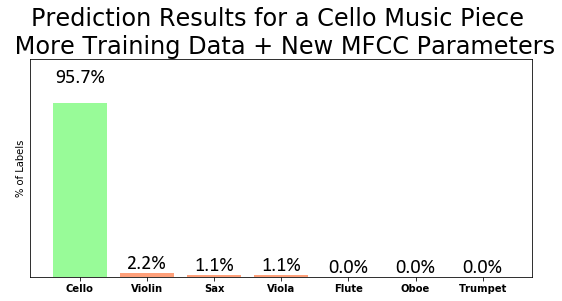

In [24]:
# Try predicting a real cello music piece
filename = './audio/Real-world_test_data/bach4.flac'

y, sr = librosa.load(filename, sr=fs)
if len(y) < 2:
    print("Error loading %s" % f)
    
feats = []
pred_freq = 2
for i in range(int(np.ceil(len(y)/sr*pred_freq))):
    ind1 = int(i*sr/pred_freq)
    ind2 = int((i+1)*sr/pred_freq-1)
    loc_y = y[ind1: ind2]
    if loc_y.max() > 0:
        loc_y /= loc_y.max() # Normalize
    feat = get_features(loc_y, sr)
    feats.append(feat)
scaled_feats = (feats-np.mean(feature_vectors))/np.std(feature_vectors)

# Save feature vectors
filename="bach4_feature_vectors.pl"
# with open(filename, "rb") as f:
#    scaled_feats = pickle.load( open( filename, "rb" ) )
with open(filename, "wb") as f:
    pickle.dump( scaled_feats, f )

# Predict instruments
label = svclassifier1.predict(scaled_feats)

# Calculate accuracy
occurrences = np.count_nonzero(labelencoder.inverse_transform(label) == 'cello')
# print('occurrences: ', occurrences)
print('Accuracy: ', occurrences/label.shape[0]*100, '%')

# with np.printoptions(threshold=np.inf):
#     print("Labels: ", labelencoder.inverse_transform(label))

# Plot histogram
plot_hist(label, 'Cello', "Prediction Results for a Cello Music Piece \n More Training Data + New MFCC Parameters")
# plot_hist(label, 'Cello', "Prediction Results for a Cello Music Piece \n More Training Data")

Accuracy:  99.36102236421725 %


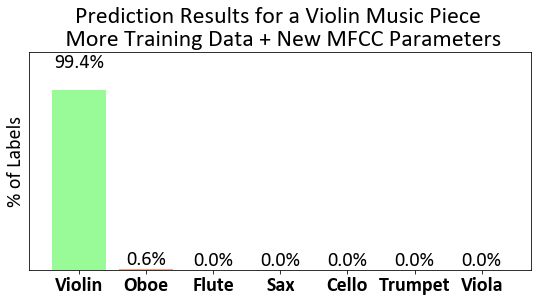

In [25]:
# Try predicting a real violin music piece
filename = './audio/Real-world_test_data/violin_4.flac'

y, sr = librosa.load(filename, sr=fs)
if len(y) < 2:
    print("Error loading %s" % f)
    
feats = []
pred_freq = 2
for i in range(int(np.ceil(len(y)/sr*pred_freq))):
    ind1 = int(i*sr/pred_freq)
    ind2 = int((i+1)*sr/pred_freq-1)
    loc_y = y[ind1: ind2]
    if loc_y.max() > 0:
        loc_y /= loc_y.max() # Normalize
#     with np.printoptions(threshold=np.inf):
#         print(loc_y)
    feat = get_features(loc_y, sr)
    feats.append(feat)
scaled_feats = (feats-np.mean(feature_vectors))/np.std(feature_vectors)

# Save feature vectors
filename = "violin_4_feature_vectors.pl"
# with open(filename, "rb") as f:
#    scaled_feats = pickle.load( open( filename, "rb" ) )
with open(filename, "wb") as f:
    pickle.dump( scaled_feats, f )

# Predict instruments
label = svclassifier1.predict(scaled_feats)

# Calculate accuracy
occurrences = np.count_nonzero(labelencoder.inverse_transform(label) == 'violin')
# print('occurrences: ', occurrences)
print('Accuracy: ', occurrences/label.shape[0]*100, '%')

# with np.printoptions(threshold=np.inf):
#     print("Labels: ", labelencoder.inverse_transform(label))

# Plot histogram
plot_hist(label, 'Violin', "Prediction Results for a Violin Music Piece \n More Training Data + New MFCC Parameters")
# plot_hist(label, 'Violin', "Prediction Results for a Violin Music Piece \n More Training Data")